### Load PC_Lab_results from BQ

In [1]:
# example: read from BigQuery chart to numpy
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
import numpy as np
import pandas as pd



client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select * from `som-nero-phi-jonc101.Clinical_Collaborative_Filtering.pc_lab_results_v2`"; # Example dataset table


# to DataFrame

df_all = (
    client.query(query)
    .result()
    .to_dataframe()
)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


### Remove unnecessary columns and rows

In [14]:
print(df_all.head())

# only take PC_enc and proc_id
df = df_all[['PC_enc', 'lab_name', 'PC_result']]

# remove duplicate rows:
df = df.drop_duplicates(['PC_enc', 'lab_name'])

print(df.head())

     jc_uid        PC_enc     PC_app_datetime     PC_ref_datetime  \
0  JCd44fac  131237396077 2017-07-14 17:51:00 2017-08-08 16:03:00   
1  JCe97b60      32550957 2009-03-29 13:15:00 2009-03-29 14:25:00   
2  JCdc3e0f  131018716402 2012-06-08 00:00:00 2012-06-08 16:55:00   
3  JCe64bc8  131066812942 2015-01-12 00:00:00 2015-01-12 14:13:00   
4  JCcc1374  131200356462 2016-10-14 00:00:00 2016-10-14 16:23:00   

                 lab_name  PC_result  
0         HCO3 (a), ISTAT          0  
1                  pH (a)          0  
2      Cholesterol, Total          0  
3  Unconjugated Bilirubin          0  
4                    HCO3          0  
         PC_enc                lab_name  PC_result
0  131237396077         HCO3 (a), ISTAT          0
1      32550957                  pH (a)          0
2  131018716402      Cholesterol, Total          0
3  131066812942  Unconjugated Bilirubin          0
4  131200356462                    HCO3          0


(519776, 3)


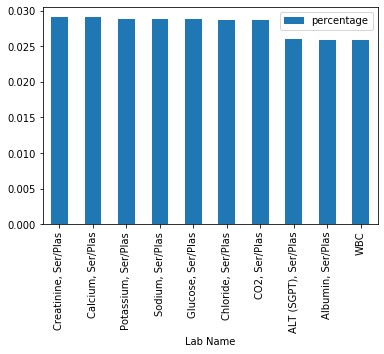

In [21]:
print(df.shape)
lendf = df.shape[0]
df_plot = df['lab_name'].value_counts().head(10).reset_index().rename(columns={'index':'Lab Name','lab_name':'percentage' })
df_plot['percentage' ]=df_plot['percentage' ]/lendf
df_plot.plot.bar(x='Lab Name',y='percentage' )

### Create the table of unique encounter id

In [3]:
unq_PC_enc = df.groupby(['PC_enc']).apply(len).reset_index().rename(columns={'lab_name':'lab_name', 0:'num_unq_proc'}).sort_values('num_unq_proc',ascending=False)  
print(len(unq_PC_enc))
print(unq_PC_enc.head())
print('All of the encounters with at least one lab result: ',len(unq_PC_enc))
print('Average lab per encounter: ', np.mean(unq_PC_enc.num_unq_proc.to_numpy()))
print('Min lab per encounter: ', np.min(unq_PC_enc.num_unq_proc.to_numpy()))
print('Max lab per encounter: ', np.max(unq_PC_enc.num_unq_proc.to_numpy()))

19225
             PC_enc  num_unq_proc
7313   131082462259            91
6925   131066588148            88
8125   131118829796            84
7821   131097590735            84
10902  131202280593            84
All of the encounters with at least one lab result:  19225
Average lab per encounter:  27.036462938881666
Min lab per encounter:  1
Max lab per encounter:  91


### Sort according to the most frequent labs (not necessarily how important they are)

In [12]:
N_lab = 100
N_proc = 100
temp_df = df.groupby(['lab_name']).apply(len).reset_index().rename(columns={'lab_name':'lab_name', 0:'num'}) #, as_index=False  

Top_proc = temp_df.sort_values('num',ascending=False).head(N_proc)['lab_name'].to_numpy()
print(Top_proc)

print(Top_proc[41:46])
#df=df.sort_values('num',ascending=False)

['Creatinine, Ser/Plas' 'Calcium, Ser/Plas' 'Potassium, Ser/Plas'
 'Sodium, Ser/Plas' 'Glucose, Ser/Plas' 'Chloride, Ser/Plas'
 'CO2, Ser/Plas' 'ALT (SGPT), Ser/Plas' 'Albumin, Ser/Plas' 'WBC' 'RBC'
 'AST (SGOT), Ser/Plas' 'Hematocrit' 'Platelet count' 'Hemoglobin' 'MCV'
 'RDW' 'MCHC' 'MCH' "Alk P'TASE, Total, Ser/Plas"
 'Protein, Total, Ser/Plas' 'Globulin' 'Anion Gap' 'eGFR' 'TSH'
 'Total Bilirubin' 'Triglyceride, Ser/Plas' 'BUN, Ser/Plas'
 'HDL Cholesterol' 'Urea Nitrogen,Ser/Plas' 'Hemoglobin A1c'
 'Total Bilirubin, Ser/Plas' 'EOS, ABS' 'Cholesterol/HDL Ratio'
 'Monocyte, Absolute' 'Lymphocyte, Absolute' 'Eosinophil, Absolute'
 'Neutrophil, Absolute' 'eGFR for African American' 'NEUT, ABS'
 'MONO, ABS' 'LYM, ABS' 'Non-HDL Chol, Calc' 'Cholesterol, Total'
 'Magnesium, Ser/Plas' 'LDL (Calculated)' 'INR' 'Prothrombin Time'
 'Glucose by Meter' '25-Hydroxy D, Total' 'pH' 'Direct LDL Chol'
 'Phosphorus, Ser/Plas' 'Part. Thromboplastin Time' 'Conjugated Bili'
 'C-Reactive Protein' 'Unconj

### Create Feature Matrix of Lab Results

In [5]:
print(df.columns)
import sys

for i in range(N_lab): #N_lab
    
    # define the function: applies on the lab results of each encounter
    def my_func(df):
        
        # Create a pandas series
        d = {}
        d['Lab'+str(i)] = 0
        d['Low'+str(i)] = 0
        d['High'+str(i)] = 0
        
        df_lab = df[df['lab_name']== Top_proc[i]]
        
        if len(df_lab)>0:
            
            d['Lab'+str(i)] = 1
            a = df_lab.PC_result.values[0] # The assumption is that each patient has only done one of each lab
            
            if a==-1:
                d['Low'+str(i)] = 1
            
            elif a==1:
                d['High'+str(i)] = 1

        return pd.Series(d) #, index=['a_sum', 'a_max', 'b_mean', 'c_d_prodsum'])
    
    
    
    F_df = df.groupby(['PC_enc']).apply(my_func).reset_index()#.rename(columns={'lab_name':'lab_name', 0:'F'+str(i)}) 
    # Encoding of the column Fi into two columns (Fi: lab result, Ti: test is done)
    
    unq_PC_enc = pd.merge(unq_PC_enc, F_df, how='left', on='PC_enc')
    
    
    
    
    # report i 
    sys.stdout.write('\r')
    sys.stdout.write(str(i/N_proc*100)+'%')
    sys.stdout.flush()


print(unq_PC_enc.head())


Index(['PC_enc', 'lab_name', 'PC_result'], dtype='object')
99.0%999999999999%%         PC_enc  num_unq_proc  Lab0  Low0  High0  Lab1  Low1  High1  Lab2  \
0  131082462259            91     1     0      1     1     0      0     1   
1  131066588148            88     1     0      0     1     0      0     1   
2  131118829796            84     1     0      1     1     0      0     1   
3  131097590735            84     1     0      0     1     0      0     1   
4  131202280593            84     1     0      0     1     0      0     1   

   Low2  ...  High96  Lab97  Low97  High97  Lab98  Low98  High98  Lab99  \
0     0  ...       1      1      1       0      1      0       0      1   
1     0  ...       1      0      0       0      0      0       0      1   
2     0  ...       1      1      1       0      1      0       0      0   
3     0  ...       1      1      0       0      1      0       0      0   
4     0  ...       1      1      0       0      1      0       0      1   

   Low99

### Save the Results into CSV

In [6]:
print(len(unq_PC_enc))
#print(unq_PC_enc.sort_values('F0',ascending=False))
#print(np.sum(unq_PC_enc['F0'].to_numpy()))
unq_PC_enc.to_csv('PC_lab_results_v3.csv', index=False)

19225


In [11]:
print(unq_PC_enc.Lab1.head(100))

0     1
1     1
2     1
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: Lab1, Length: 100, dtype: int64
